# Malware detection

A toy dataset for malware detection. It contains only two classes (benign and malware).

This notebook will address the topic of feature importance and feature selection.

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 7]

2023-11-17 01:02:15.878924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pl.read_csv('https://cloud.hrun.duckdns.org/s/CSEFd6fBQRnryk2/download/malware_dataset.csv')
df.head()

hash,millisecond,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""42fb5e2ec009a0…",0,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a0…",1,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a0…",2,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a0…",3,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a0…",4,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0


In [3]:
mapping = {'benign':0, 'malware':1} 
df = df.with_columns(pl.col('classification').map_dict(mapping).alias('classification'))

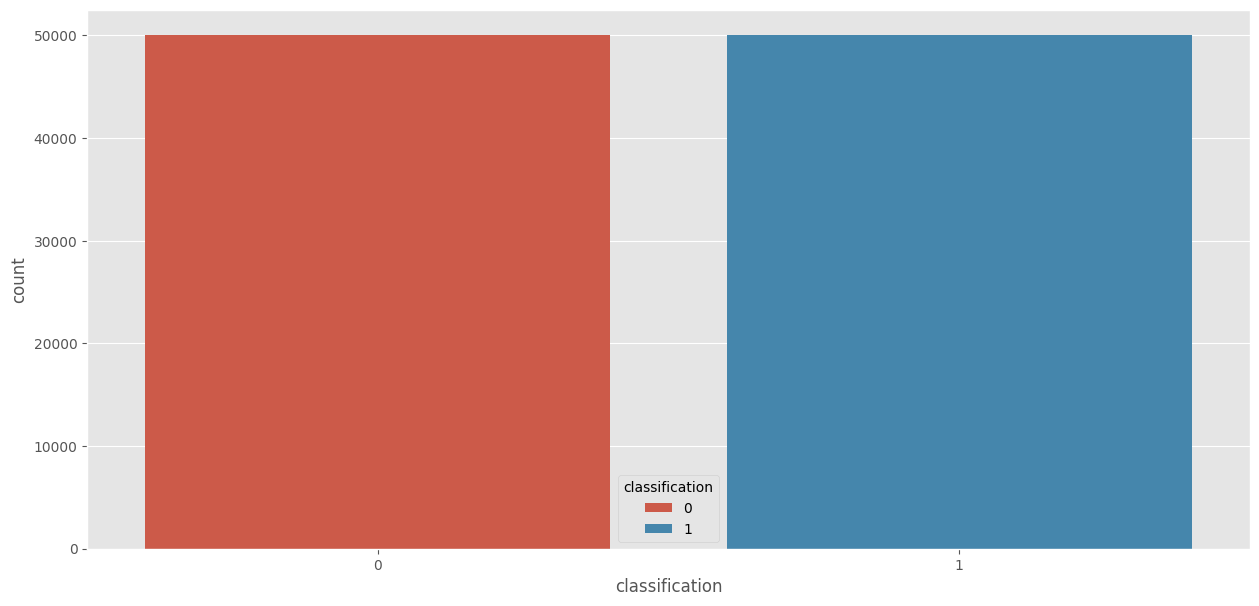

In [4]:
sns.countplot(data=df, x='classification', hue='classification')
plt.show()

In [5]:
df = df.drop(['hash', 'millisecond'])
df.describe()

describe,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.5,157768.33536,0.0,3.0697e9,18183.90007,0.0,0.0,0.0,15312.73951,0.0,0.0,9.58777,728.46543,8771.13948,0.0,266.49112,117.92024,127.67815,205.32485,0.0,117.92024,2435.97361,348313.0716,32.99116,2.05313,117.92024,1.10919,3.2044e9,385415.45197,4.05931,1.66142,0.0,0.0
"""std""",0.500003,936172.583333,0.0,296306.144183,4609.792765,0.0,0.0,0.0,3256.475008,0.0,0.0,46.504908,84.475361,3785.30516,0.0,311.996779,3.116892,22.277995,112.717875,0.0,3.116892,2605.564669,9117.720632,52.730176,13.881382,3.116892,2.160466,0.0,10144.036494,0.822848,3.26304,0.0,0.0
"""min""",0.0,0.0,0.0,3.0692e9,13988.0,0.0,0.0,0.0,9695.0,0.0,0.0,0.0,612.0,2588.0,0.0,4.0,112.0,92.0,29.0,0.0,112.0,0.0,337688.0,0.0,0.0,112.0,0.0,3.2044e9,371782.0,3.0,0.0,0.0,0.0
"""25%""",0.0,0.0,0.0,3.0695e9,14352.0,0.0,0.0,0.0,12648.0,0.0,0.0,0.0,651.0,6428.0,0.0,99.0,114.0,112.0,112.0,0.0,114.0,0.0,341974.0,1.0,0.0,114.0,0.0,3.2044e9,378208.0,3.0,0.0,0.0,0.0
"""50%""",1.0,0.0,0.0,3.0697e9,16159.0,0.0,0.0,0.0,15245.0,0.0,0.0,1.0,725.0,7865.0,0.0,177.0,120.0,127.0,193.0,0.0,120.0,2017.0,347244.0,9.0,1.0,120.0,0.0,3.2044e9,383637.0,4.0,0.0,0.0,0.0
"""75%""",1.0,4096.0,0.0,3.0700e9,22182.0,0.0,0.0,0.0,17663.0,0.0,0.0,4.0,785.0,10684.0,0.0,327.0,120.0,138.0,273.0,0.0,120.0,4036.0,351667.0,46.0,1.0,120.0,1.0,3.2044e9,390324.0,5.0,1.0,0.0,0.0
"""max""",1.0,4.3266048e7,0.0,3.0702e9,31855.0,0.0,0.0,0.0,27157.0,0.0,0.0,515.0,995.0,28184.0,0.0,2810.0,120.0,196.0,755.0,0.0,120.0,9526.0,384520.0,365.0,256.0,120.0,18.0,3.2044e9,421913.0,7.0,15.0,0.0,0.0


## Drop columns with low variance

In [6]:
threshold = 0.5
df = df.drop([col.name for col in df.select(pl.all().std() < threshold) if col.item()])
df.describe()

describe,classification,state,prio,static_prio,vm_truncate_count,free_area_cache,mm_users,map_count,total_vm,shared_vm,exec_vm,reserved_vm,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,utime,stime,gtime
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.5,157768.33536,3.0697e9,18183.90007,15312.73951,9.58777,728.46543,8771.13948,266.49112,117.92024,127.67815,205.32485,117.92024,2435.97361,348313.0716,32.99116,2.05313,117.92024,1.10919,385415.45197,4.05931,1.66142
"""std""",0.500003,936172.583333,296306.144183,4609.792765,3256.475008,46.504908,84.475361,3785.30516,311.996779,3.116892,22.277995,112.717875,3.116892,2605.564669,9117.720632,52.730176,13.881382,3.116892,2.160466,10144.036494,0.822848,3.26304
"""min""",0.0,0.0,3.0692e9,13988.0,9695.0,0.0,612.0,2588.0,4.0,112.0,92.0,29.0,112.0,0.0,337688.0,0.0,0.0,112.0,0.0,371782.0,3.0,0.0
"""25%""",0.0,0.0,3.0695e9,14352.0,12648.0,0.0,651.0,6428.0,99.0,114.0,112.0,112.0,114.0,0.0,341974.0,1.0,0.0,114.0,0.0,378208.0,3.0,0.0
"""50%""",1.0,0.0,3.0697e9,16159.0,15245.0,1.0,725.0,7865.0,177.0,120.0,127.0,193.0,120.0,2017.0,347244.0,9.0,1.0,120.0,0.0,383637.0,4.0,0.0
"""75%""",1.0,4096.0,3.0700e9,22182.0,17663.0,4.0,785.0,10684.0,327.0,120.0,138.0,273.0,120.0,4036.0,351667.0,46.0,1.0,120.0,1.0,390324.0,5.0,1.0
"""max""",1.0,4.3266048e7,3.0702e9,31855.0,27157.0,515.0,995.0,28184.0,2810.0,120.0,196.0,755.0,120.0,9526.0,384520.0,365.0,256.0,120.0,18.0,421913.0,7.0,15.0


## Split the data

In [7]:
Y = df['classification'].to_numpy()
X = df.drop(['classification']).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

X.shape

(100000, 21)

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

def create_model():
    nn = models.Sequential([
    layers.Dense(32, input_dim=X.shape[1], kernel_initializer='glorot_uniform', activation="relu"),
    layers.Dense(16, kernel_initializer='glorot_uniform', activation="relu"),
    layers.Dense(1, kernel_initializer='glorot_uniform', activation="sigmoid")])
    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return nn

create_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                704       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
from scikeras.wrappers import KerasClassifier

clf = KerasClassifier(model=create_model, verbose=0, epochs=10, batch_size=128)

# fit the model
clf.fit(X_train, y_train)

KerasClassifier(
	model=<function create_model at 0x7f1df5c10040>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)

In [11]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     10030
     Malware       1.00      1.00      1.00      9970

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



## Using Keras Directly

In [12]:
# create model
nn = models.Sequential()

nn.add(layers.Dense(16, input_dim=X.shape[1], kernel_initializer='glorot_uniform', activation="relu"))
nn.add(layers.Dense(8, kernel_initializer='glorot_uniform', activation="relu"))
nn.add(layers.Dense(1, kernel_initializer='glorot_uniform', activation="sigmoid"))

nn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                352       


                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history = nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1576 - accuracy: 0.9396 - val_loss: 0.0377 - val_accuracy: 0.9869
Epoch 2/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0191 - accuracy: 0.9947 - val_loss: 0.0109 - val_accuracy: 0.9978
Epoch 3/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0048 - val_accuracy: 0.9981
Epoch 4/10
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 0.0021 - val_accuracy: 0.9994
Epoch 5/10
2500/2500 [==============================] - 2s 988us/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0018 - val_accuracy: 0.9995
Epoch 6/10
2500/2500 [==============================] - 2s 976us/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 7/10
2500/2500 [==============================] - 2s 981us/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0013 - val_acc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


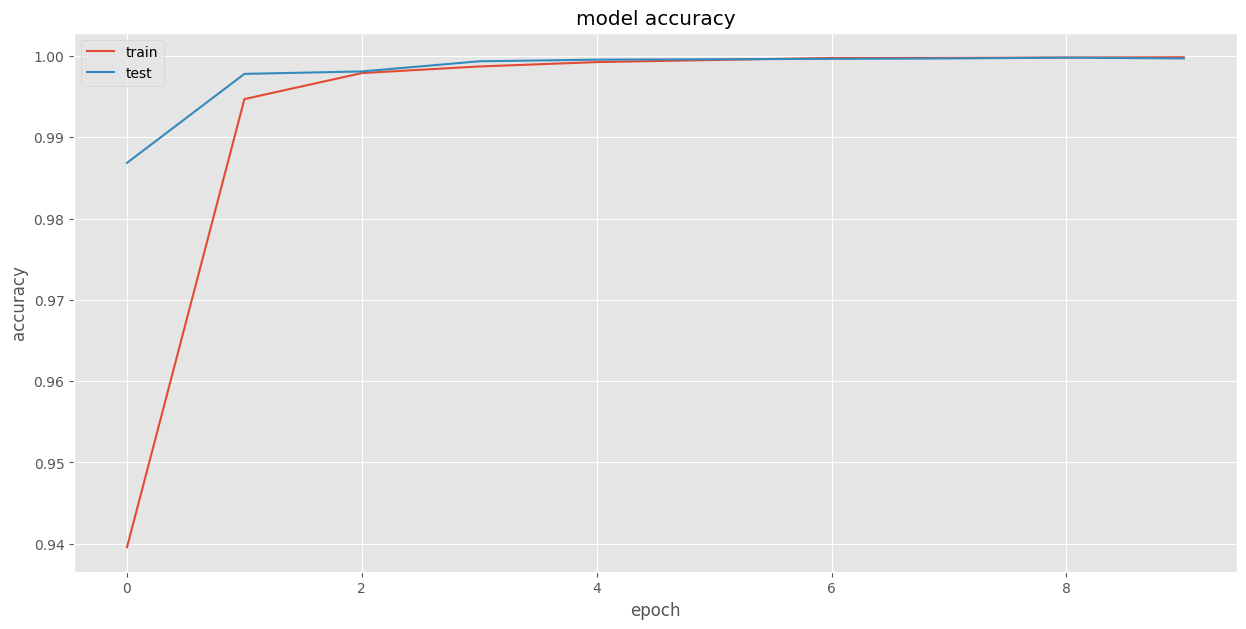

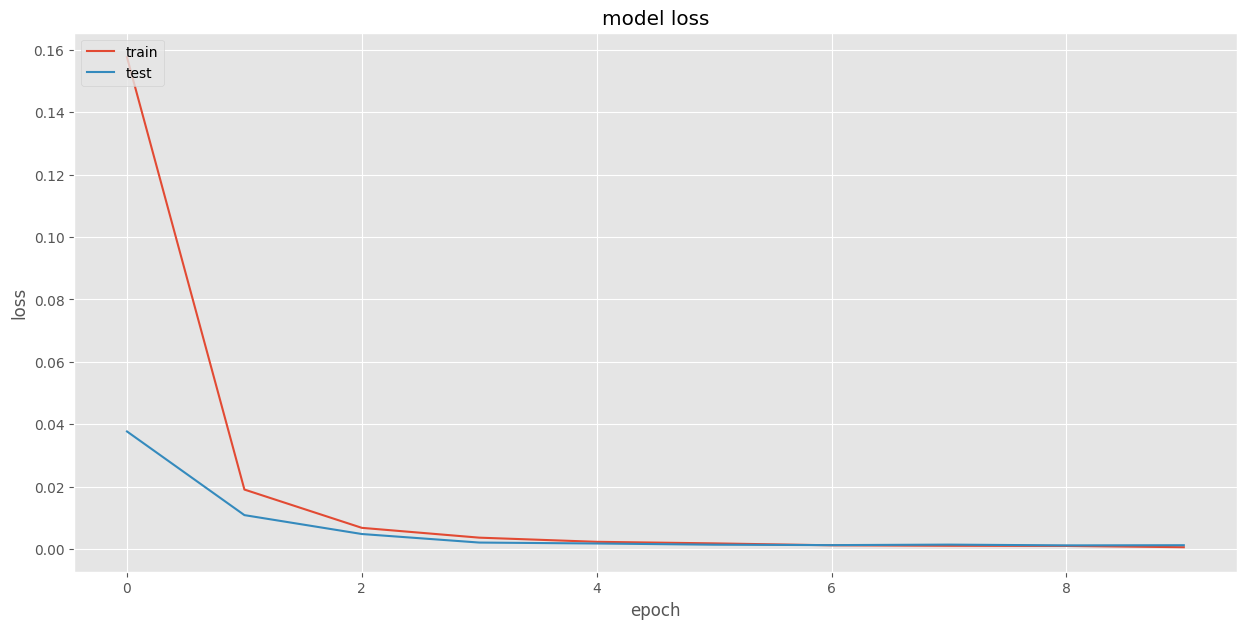

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()